<a href="https://colab.research.google.com/github/gahyunson/food_management/blob/main/%08food_resnetmodeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 구글 드라이브 연결과 경로 이동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd drive/MyDrive/final_project/

[Errno 2] No such file or directory: 'drive/MyDrive/final_project/'
/content


# 한글 폰트 설정

In [ ]:
# 한글 폰트 설치하기 (꼭! 설치가 완료되면 [런타임 다시 시작]을 누르고 다시 실행하기)
#!apt install fonts-nanum -y

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정하기
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='NanumBarunGothic')
matplotlib.font_manager._rebuild()

# 이미지 읽어오기 테스트

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


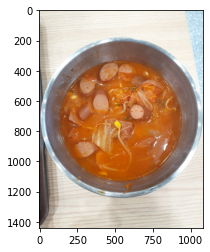

In [ ]:
img_basic = cv2.imread(data_dir+'test/04_046_04016001_160794302732952_0.jpg', cv2.IMREAD_COLOR)
plt.imshow(cv2.cvtColor(img_basic, cv2.COLOR_BGR2RGB))
plt.show()

# resnet34 이용한 모델링


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time

import os
import shutil

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

In [ ]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = '/content/drive/MyDrive/final_project/food_img/'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)


In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 1500
테스트 데이터셋 크기: 30
클래스: ['01011001', '01015010', '01015013', '04016001', '12011008']


In [ ]:
# 사전 훈련 모델로 resnet34 사용
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 5)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


# model.fc.in_features : fully-connected에 입력되는 데이터 수 값
# https://steemit.com/kr/@codingart/7-30-pytorch-transfer-learning-iv-fine-tuning

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
num_epochs = 50
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.cuda(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

#0 Loss: 0.7802 Acc: 71.6000% Time: 227.7923s
#1 Loss: 0.5198 Acc: 83.1333% Time: 352.3041s
#2 Loss: 0.4198 Acc: 86.8000% Time: 477.4464s
#3 Loss: 0.3624 Acc: 88.3333% Time: 609.4362s
#4 Loss: 0.2344 Acc: 92.7333% Time: 730.6010s
#5 Loss: 0.1609 Acc: 93.9333% Time: 854.2369s
#6 Loss: 0.1641 Acc: 94.5333% Time: 977.5553s
#7 Loss: 0.0787 Acc: 97.2667% Time: 1100.2828s
#8 Loss: 0.1293 Acc: 96.3333% Time: 1222.6062s
#9 Loss: 0.1075 Acc: 97.1333% Time: 1344.3466s
#10 Loss: 0.0995 Acc: 97.4000% Time: 1467.0187s
#11 Loss: 0.1090 Acc: 96.8000% Time: 1588.8764s
#12 Loss: 0.0757 Acc: 98.0000% Time: 1710.9012s
#13 Loss: 0.0426 Acc: 98.9333% Time: 1834.2841s
#14 Loss: 0.0908 Acc: 97.4667% Time: 1957.1381s
#15 Loss: 0.0767 Acc: 98.1333% Time: 2078.7514s
#16 Loss: 0.0846 Acc: 97.7333% Time: 2200.9304s
#17 Loss: 0.0614 Acc: 98.6000% Time: 2323.6018s
#18 Loss: 0.0608 Acc: 98.7333% Time: 2446.4723s
#19 Loss: 0.0569 Acc: 98.8000% Time: 2568.5000s
#20 Loss: 0.0284 Acc: 99.3333% Time: 2692.8763s
#21 Loss:

In [ ]:
torch.save(model, './drive/MyDrive/final_project/model/model_pytorch2.pt')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[예측 결과: 01015013] (실제 정답: 01015013)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_te

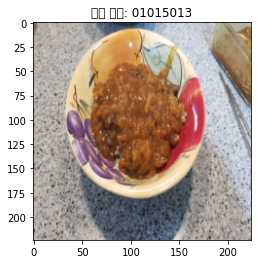

[예측 결과: 04016001] (실제 정답: 04016001)


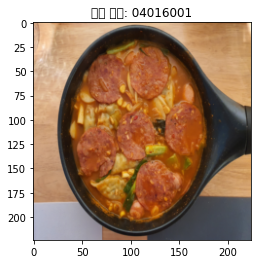

[예측 결과: 04016001] (실제 정답: 04016001)


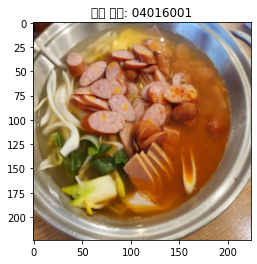

[예측 결과: 12011008] (실제 정답: 12011008)


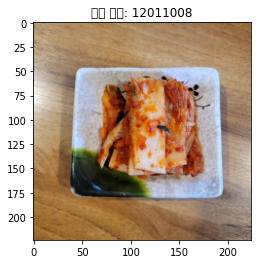

[예측 결과: 01011001] (실제 정답: 01011001)


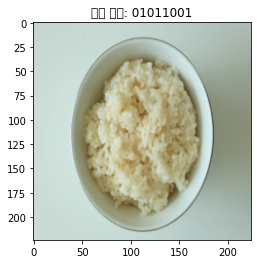

[예측 결과: 01011001] (실제 정답: 01011001)


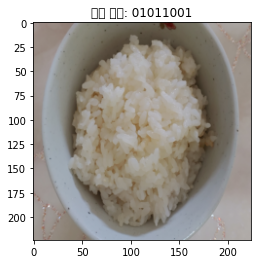

[예측 결과: 01015010] (실제 정답: 01015010)


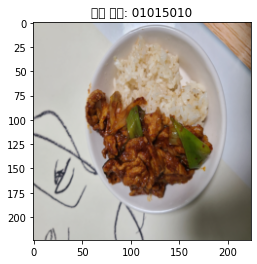

[예측 결과: 12011008] (실제 정답: 12011008)


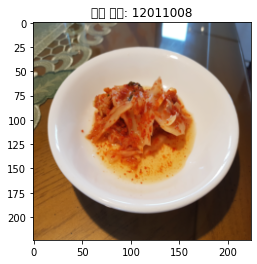

[Test Phase] Loss: 0.0011 Acc: 100.0000% Time: 9.4741s


In [ ]:
model.eval() # layer들의 동작을 inference(eval) mode로 변경
start_time = time.time()

with torch.no_grad(): # autograd engine 기능(자동 미분 엔진)을 off해준다.
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))